In [39]:


import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [40]:
# Paths to your dataset folders
class_paths = [
    r"D:\segmented_images\0", 
    r"D:\segmented_images\1", 
    r"D:\segmented_images\2", 
    r"D:\segmented_images\3", 
    r"D:\segmented_images\4"
]

In [41]:
# Set constants
img_size = 224  # Resize images to 224x224 for ResNet50
num_classes = 5  # We have 5 classes

In [42]:
# Initialize arrays for storing data and labels
X = []  # Image data
y = []  # Labels

In [43]:
# Load and preprocess the data
for class_label, folder in enumerate(class_paths):
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))  # Resize image to 224x224
            img = np.stack((img,) * 3, axis=-1)  # Convert grayscale to 3-channel by duplicating the channel
            X.append(img)
            y.append(class_label)


In [44]:
# Convert lists to numpy arrays
X = np.array(X)  # No need to reshape as ResNet expects 3-channel (RGB) images
y = np.array(y)

In [45]:
# Normalize pixel values (scale between 0 and 1)
X = X / 255.0

In [46]:
# Convert labels to categorical (one-hot encoding)
y = to_categorical(y, num_classes)

In [47]:

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [49]:
# Compute class weights to address imbalance
y_train_classes = np.argmax(y_train, axis=1)  # Convert one-hot encoded to class labels
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',  # Use balanced mode to handle class imbalance
    classes=np.unique(y_train_classes),  # Provide the unique class labels
    y=y_train_classes  # The class labels for the training data
)
class_weights_dict = dict(enumerate(class_weights))  # Convert to dictionary format


In [50]:
# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

In [51]:
# Load ResNet50 model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))


In [52]:
# Freeze all layers except the last few for fine-tuning
for layer in base_model.layers[:-10]:
    layer.trainable = False


In [54]:
# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Use global average pooling to reduce dimensions
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Freeze the base model (ResNet50 layers)
base_model.trainable = False

In [55]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [56]:
# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=25,
    callbacks=[early_stopping]
)

C:\Users\C RISHI VARDHAN REDD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.1975 - loss: 1.8600 - val_accuracy: 0.2268 - val_loss: 1.6035
Epoch 2/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.1994 - loss: 1.6241 - val_accuracy: 0.1890 - val_loss: 1.6097
Epoch 3/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.2016 - loss: 1.6095 - val_accuracy: 0.1890 - val_loss: 1.6092
Epoch 4/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.1951 - loss: 1.6095 - val_accuracy: 0.1890 - val_loss: 1.6084
Epoch 5/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.2070 - loss: 1.6089 - val_accuracy: 0.1890 - val_loss: 1.6078
Epoch 6/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.2083 - loss: 1.6089 - val_accuracy: 0.1890 - val_loss: 1.6076


In [58]:

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc * 100:.2f}%')

10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.2118 - loss: 1.6000
Test accuracy: 22.68%


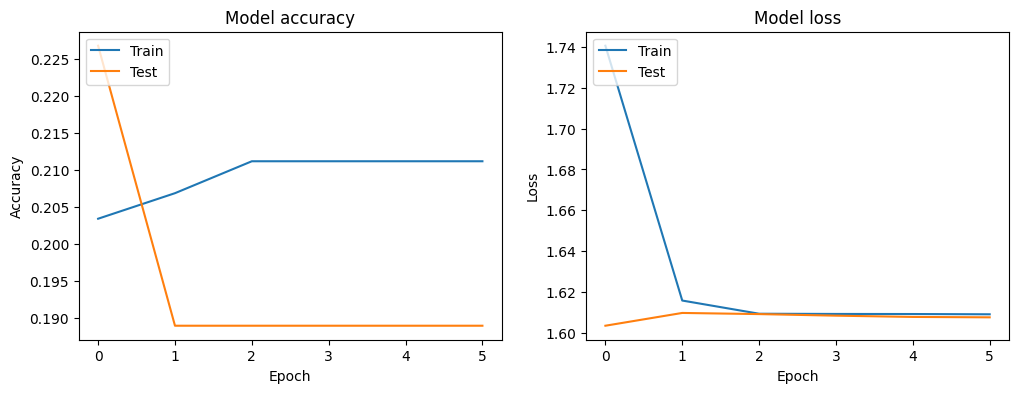

In [59]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


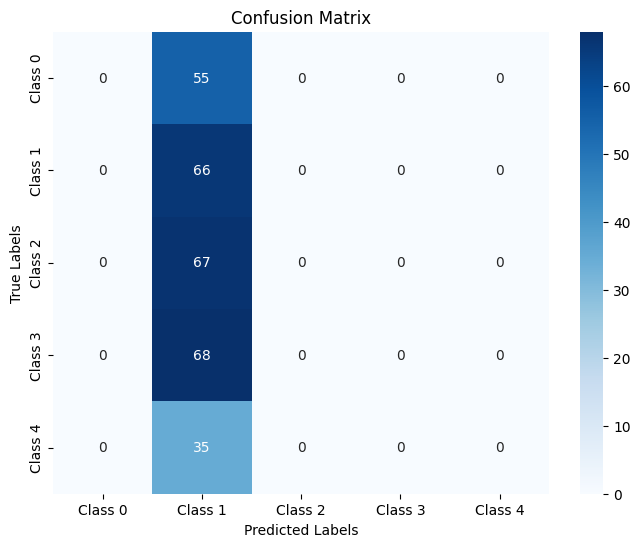

In [60]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the labels for the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot encoded predictions to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded test labels to class labels

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=[f'Class {i}' for i in range(num_classes)], yticklabels=[f'Class {i}' for i in range(num_classes)])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()